In [ ]:
google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install matplotlib numpy Pillow tensorflow

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
import pathlib
dataset = "/content/drive/MyDrive/rope_skipping/Dataset_Balanced"
data_dir = pathlib.Path(dataset)

In [ ]:
print(data_dir)

/content/drive/MyDrive/rope_skipping/Dataset_Balanced


In [ ]:
img_height, img_width= 180, 180
batch_size = 32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split = 0.2,
  subset = "training",
  seed = 123,
  image_size = (img_height, img_width),
  batch_size = batch_size)

Found 5148 files belonging to 2 classes.
Using 4119 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split = 0.2,
  subset="validation",
  seed = 123,
  image_size = (img_height, img_width),
  batch_size = batch_size)

Found 5148 files belonging to 2 classes.
Using 1029 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['not_skipping', 'skipping']


In [ ]:
label_map = {"skipping": 1, "not_skipping": 0}
encoded_labels = [label_map[label] for label in class_names]
encoded_labels = np.array(encoded_labels)

In [ ]:
def identity_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [ ]:
def convolutional_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same', strides = (2,2))(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Processing Residue with conv(1,1)
    x_skip = tf.keras.layers.Conv2D(filter, (1,1), strides = (2,2))(x_skip)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [ ]:
def ResNet34(shape = (180, 180, 3), classes = 2):
    # Step 1 (Setup Input Layer)
    x_input = tf.keras.layers.Input(shape)
    x = tf.keras.layers.ZeroPadding2D((3, 3))(x_input)
    # Step 2 (Initial Conv layer along with maxPool)
    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    # Define size of sub-blocks and initial filter size
    block_layers = [3, 4, 6, 3]
    filter_size = 64
    # Step 3 Add the Resnet Blocks
    for i in range(4):
        if i == 0:
            # For sub-block 1 Residual/Convolutional block not needed
            for j in range(block_layers[i]):
                x = identity_block(x, filter_size)
        else:
            # One Residual/Convolutional Block followed by Identity blocks
            # The filter size will go on increasing by a factor of 2
            filter_size = filter_size*2
            x = convolutional_block(x, filter_size)
            for j in range(block_layers[i] - 1):
                x = identity_block(x, filter_size)
    # Step 4 End Dense Network
    x = tf.keras.layers.AveragePooling2D((2,2), padding = 'same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)
    model = tf.keras.models.Model(inputs = x_input, outputs = x, name = "ResNet34")
    return model

In [ ]:
model = ResNet34()

In [ ]:
model.summary()

Model: "ResNet34"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 180, 180, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 186, 186, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv2d (Conv2D)             (None, 93, 93, 64)           9472      ['zero_padding2d[0][0]']      
                                                                                                  
 batch_normalization (Batch  (None, 93, 93, 64)           256       ['conv2d[0][0]']       

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
epochs = 2000

# Create a folder for the current run
run_folder = os.path.join('/content/drive/MyDrive/rope_skipping/runs', f'{epochs}-epochs')
os.makedirs(run_folder, exist_ok=True)

# Define the weights folder inside the run folder
weights_folder = os.path.join(run_folder, 'weights')
os.makedirs(weights_folder, exist_ok=True)

In [ ]:
best_weight = os.path.join(weights_folder, 'best.h5')
last_weight = os.path.join(weights_folder, 'last.h5')

In [ ]:
checkpoint_callback = ModelCheckpoint(filepath=best_weight, save_best_only=True, save_weights_only=True)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[checkpoint_callback, early_stopping]
)
model.save_weights(last_weight)

Epoch 1/2000
129/129 [==============================] - 937s 6s/step - loss: 1.1876 - accuracy: 0.6599 - val_loss: 4134.5127 - val_accuracy: 0.4840
Epoch 2/2000
129/129 [==============================] - 32s 240ms/step - loss: 0.6148 - accuracy: 0.7410 - val_loss: 0.9208 - val_accuracy: 0.4840
Epoch 3/2000
129/129 [==============================] - 32s 238ms/step - loss: 0.4487 - accuracy: 0.8043 - val_loss: 0.6372 - val_accuracy: 0.7143
Epoch 4/2000
129/129 [==============================] - 32s 239ms/step - loss: 0.3602 - accuracy: 0.8548 - val_loss: 0.4420 - val_accuracy: 0.8066
Epoch 5/2000
129/129 [==============================] - 32s 238ms/step - loss: 0.2938 - accuracy: 0.8835 - val_loss: 0.3432 - val_accuracy: 0.8737
Epoch 6/2000
129/129 [==============================] - 30s 224ms/step - loss: 0.2264 - accuracy: 0.9102 - val_loss: 0.4333 - val_accuracy: 0.8047
Epoch 7/2000
129/129 [==============================] - 32s 241ms/step - loss: 0.2134 - accuracy: 0.9170 - val_loss: 

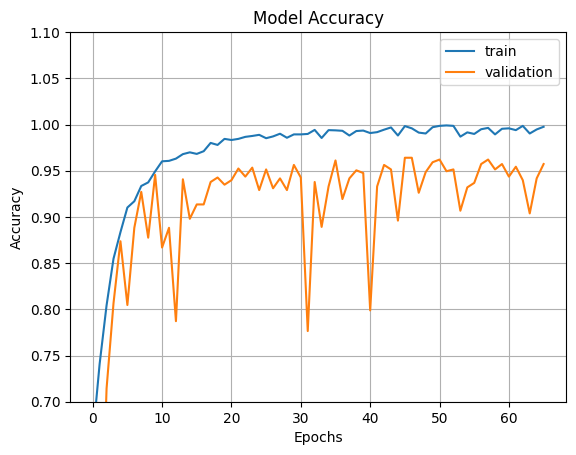

In [ ]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.7,ymax=1.1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

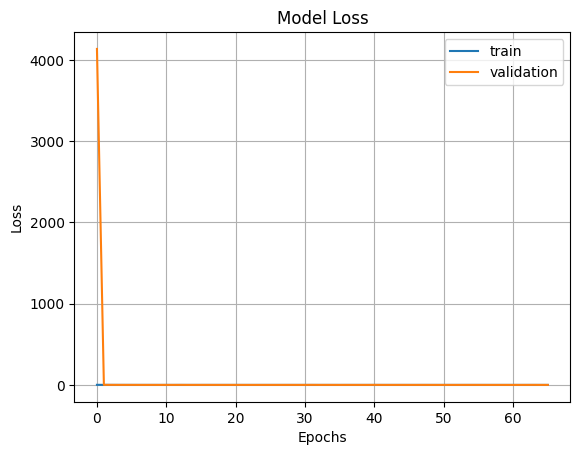

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Assuming you have already trained your model and obtained predictions
# You can use the model to predict labels for the validation dataset
val_predictions = model.predict(val_ds)

# Assuming val_ds is a tuple (images, labels), where labels are binary (0 or 1)
# Convert the labels to binary (0 or 1) based on your task
val_true_labels = np.concatenate([y for _, y in val_ds], axis=0)  # Assuming val_ds is a tf.data.Dataset object

# Compute precision, recall, and F1-score using scikit-learn's classification_report
report = classification_report(val_true_labels, (val_predictions > 0.5).astype(int))
print(report)

33/33 [==============================] - 7s 139ms/step
              precision    recall  f1-score   support

           0       0.51      0.50      0.50       498
           1       0.54      0.54      0.54       531

    accuracy                           0.52      1029
   macro avg       0.52      0.52      0.52      1029
weighted avg       0.52      0.52      0.52      1029



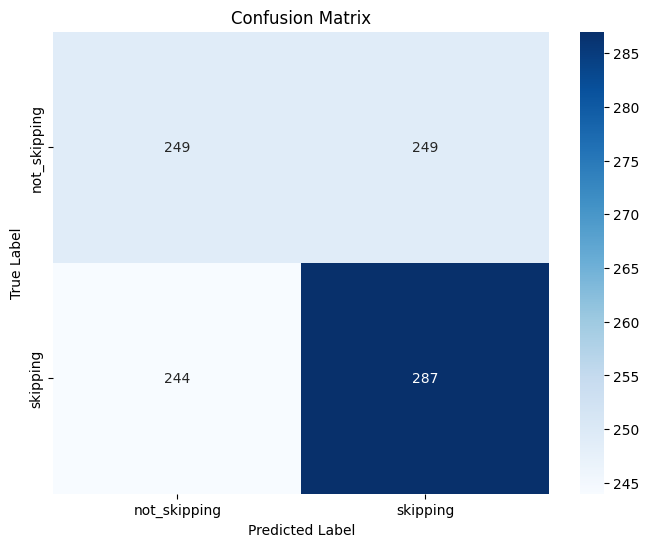

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define the class labels (assuming binary classification)
class_labels = ['not_skipping', 'skipping']

# Assuming you have already trained your model and obtained predictions
# val_predictions: predicted probabilities or labels from your model
# val_true_labels: true binary labels for the validation dataset

# Convert predicted probabilities to binary labels based on a threshold (e.g., 0.5)
val_pred_labels = (val_predictions > 0.5).astype(int)

# Compute the confusion matrix with labeled rows and columns
cm = confusion_matrix(val_true_labels, val_pred_labels, labels=[0, 1])

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()